In [ ]:
%load_ext autoreload
%autoreload 2

In [25]:
# Setup output and imports
from tslib import ts_import, ts_output, ts_log, ts_csvout
PROG = "pplate-defl-designA"      # This experiment's ID
OUT_D = ts_output(PROG)           # Output file directory

# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import root_scalar

libem = ts_import("libem", "20211006")
cmp = ts_import("components", "20211006")
rlm = ts_import("realmodel", "20211004")
libvis = ts_import("libvis", "20211027")

Results directory already exists: results\pplate-defl-designA20211027


## Set up dimensions and conversions

In [26]:
conv = rlm.Conversion(
    mass=1, # 1 electron mass / sim unit
    length=1, # 1cm / sim unit
    time=1,
    charge=1,
    voltage=1
)

# Goal for deflection voltage is 10V for 200eV ions

DFDIM = {
    "length": conv.real_to_sim(3, "length"), # ideal is 3cm
    "box": conv.real_to_sim(2, "length"),
    "diam": conv.real_to_sim(1, "length"),
    "boxwall": conv.real_to_sim(0.2, "length"),

    "panel_l": conv.real_to_sim(2, "length"),
    "panel_w": conv.real_to_sim(1.6, "length"),
    "panel_h": conv.real_to_sim(0.2, "length"),
    "panel_gap": conv.real_to_sim(1, "length")
}

SPACE_SIZE = [round(DFDIM["length"] * 1.5), round(DFDIM["box"] * 1.5), round(DFDIM["box"] * 1.5)]
SPACE_TLFT = [-(s / 2.0) for s in SPACE_SIZE]

SCALE = 20

ts_log(PROG, "SIMULATION SPACE SIZE:", ", ".join([str(s) for s in SPACE_SIZE]))
ts_log(PROG, "SIMULATION SPACE TOP_LEFT:", ", ".join([str(tl) for tl in SPACE_TLFT]))
ts_log(PROG, "SIMULATION SCALE SET AT:", SCALE, "->", np.prod(SCALE * np.array(SPACE_SIZE)), " POINTS")


SIMULATION SPACE SIZE: 4, 3, 3
SIMULATION SPACE TOP_LEFT: -2.0, -1.5, -1.5
SIMULATION SCALE SET AT: 20 -> 288000  POINTS


## Gate generator

In [27]:
def generate_dfgate(panel_pos, panel_dim, body_V, hole_V, electrode_V):
    # Create simulation space from global parameters
    sim = libem.EMSimulationSpace3D(space_size=SPACE_SIZE, top_left=SPACE_TLFT, scale=SCALE)

    # CREATE GATE COMPONENTS
    # Body - Hollow Rectangular Prism
    body = (
        (-(DFDIM["length"] / 2.0), -(DFDIM["box"] / 2.0), -(DFDIM["box"] / 2.0)),
        (DFDIM["length"], DFDIM["box"], DFDIM["box"]),
        DFDIM["boxwall"],
        body_V
    )
    # End Holes - Closed Cylinders
    ehole_0_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        (-(DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0
    )
    ehole_1_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        ((DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0,
        direction=-1
    )
    # Deflection Panel - Rectangular Prism
    top_panel = (
        (*panel_pos[:2], panel_pos[3]),
        panel_dim,
        -electrode_V
    )
    bottom_panel = (
        (*panel_pos[:2], panel_pos[2]),
        panel_dim,
        electrode_V
    )

    # Generate boundary enforcer
    enf = [
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_hollow, *body),
        cmp.enf(-1, cmp.EMObjects.arbitrary_mask, ehole_0_mask, hole_V),
        cmp.enf(-1, cmp.EMObjects.arbitrary_mask, ehole_1_mask, hole_V),
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_solid, *top_panel),
        cmp.enf(+1, cmp.EMObjects.rectangular_prism_solid, *bottom_panel)
    ]

    return sim, enf


## Visualize Particle Path

Visualizing the deflection gate with particle path.
 - Computing electric field
 - Computing particle motion
 - Rendering 2D Electric Field Cross-Sections at 0 with Motion
Particle path experiment ran.


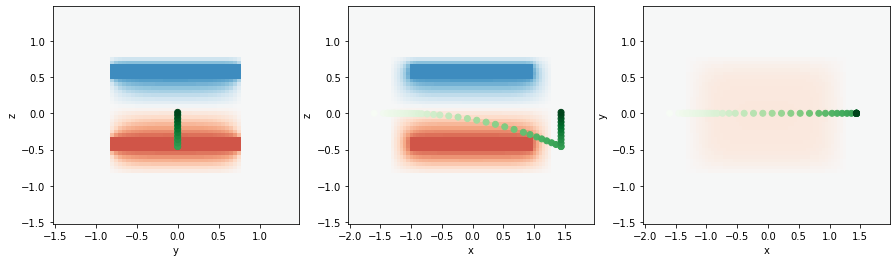

In [32]:
PARTICLE_OPTS = {
    "mass": (conv.real_to_sim(1, "mass"), conv.real_to_sim(0.5, "mass")),
    "charge": (conv.real_to_sim(1, "charge"), conv.real_to_sim(0.5, "charge")),
    "initial_loc": (
        (conv.real_to_sim(-(DFDIM["length"] / 2.0) - 0.1, "length"), 0, 0),
        (0, 0, 0)
    ),
    "initial_v": (
        (conv.real_to_sim(1, "length / time"), 0, 0),
        (conv.real_to_sim(0.1, "length / time"), conv.real_to_sim(0.1, "length / time"), conv.real_to_sim(0.1, "length / time"))
    ),
    "bounce_coef": 1
}

def visualize_dfgate_particle(particle_opts, panel_pos, body_V, hole_V, electrode_V):
    V_norm = max(abs(electrode_V), abs(hole_V), abs(body_V), 0.1)

    print("Visualizing the deflection gate with particle path.")
    sim, enf = generate_dfgate(
        panel_pos,
        (DFDIM["panel_l"], DFDIM["panel_w"], DFDIM["panel_h"]),
        body_V, hole_V, electrode_V)
    print(" - Computing electric field")
    sim.compute(enf)
    sim.get_efield()
    print(" - Computing particle motion")
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       particle_opts["initial_loc"][0],
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))
    print(" - Rendering 2D Electric Field Cross-Sections at 0 with Motion")


    
    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        libvis.Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)
        libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

    # Save the simulation results
    # Columns: MASS, CHARGE, X_0, Vx_0, Vy_0, Vz_0, BOUNCE, X_1, Y_1, Z_1
    ts_csvout(PROG, "particle_paths.csv",
        [particle_opts["mass"][0], particle_opts["charge"][0], particle_opts["initial_loc"][0][0], *particle_opts["initial_v"][0],
        particle_opts["bounce_coef"], *particle.position.T[-1]]
    )
    # Save image
    plt.savefig(OUT_D + "/ppath.png")
    # Log
    ts_log(PROG, "Particle path experiment ran.")


visualize_dfgate_particle(
    PARTICLE_OPTS,
    (-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), -DFDIM["panel_gap"] / 2.0, DFDIM["panel_gap"] / 2.0),
    0, 0, -0.063
)


   0 -> 1.4
   1.0 -> -0.68
   0.674 -> -0.71
   0.327 -> -0.57
   0.163 -> -0.4
   0.11 -> -1.67
   0.055 -> 1.32
   0.086 -> -1.29
   0.07 -> -0.91
=> Minimum V: 0.062
c:\Users\furma\Google Drive (adam_furman@brown.edu)\Miscellaneous\Stein Lab\TOFSim
Found Minium Voltage: 0.06247194640492988


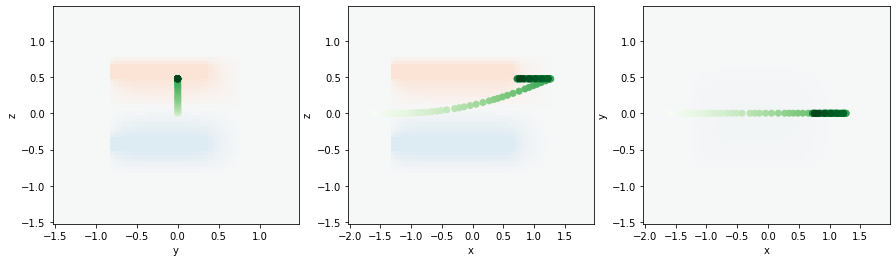

In [29]:
def generate_minV_space(particle_opts, visualize=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    video = libvis.VideoMaker(fig, axs)

    qKe = particle_opts["charge"][0] * (particle_opts["mass"][0] / 2.0) * (particle_opts["initial_v"][0][0]**2)

    def voltage_fn(V):
        # Returns a negative value if stopped "too soon", or a positive one if the particle escapes.
        sim, enf = generate_dfgate(
            (-(DFDIM["length"] / 2.0) + DFDIM["boxwall"], -(DFDIM["box"] / 2.0) + DFDIM["boxwall"], -(DFDIM["panel_gap"] / 2.0), DFDIM["panel_gap"] / 2.0),
            (DFDIM["panel_l"], DFDIM["panel_w"] - (2 * DFDIM["boxwall"]), DFDIM["panel_h"]),
            0, 0, V)

        sim.compute(enf)
        sim.get_efield()

        particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                        (particle_opts["initial_loc"][0][0], 0, 0),
                                        particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
        particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))

        if visualize:
            video.new_frame()

            labels = ["x", "y", "z"]
            for i, ax in enumerate(axs):
                sub_label = labels[:]
                sub_label.pop(i)
                ax.set_xlabel(sub_label[0])
                ax.set_ylabel(sub_label[1])

                sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
                libvis.Visualizations.colormesh_2d(sim2d, color_norm=qKe, graph_ax=ax)
                libvis.Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)

            video.draw_frame()

        metric = 0
        if particle.position[0,-1] > DFDIM["length"] / 2.0:
            metric = particle.position[0,-1] - (DFDIM["length"] / 2.0)
        else:
            metric = -1 * (np.max(particle.position[1]**2) + np.max(particle.position[2]**2)) * particle.num_bounces

        print("  ", round(V, 3), "->", round(metric, 2))
        return metric

    min_v = root_scalar(
        voltage_fn,
        method="toms748",
        bracket=(0, 2 * qKe),
        xtol=qKe / 20.0,
        x0=qKe / 2.0
    )
    print("=> Minimum V:", round(min_v.root, 3))

    if visualize: video.make_movie(OUT_D, "minimize_V.mp4")

    return min_v.root, min_v.root / qKe

min_v, min_v_qke_ratio = generate_minV_space(
    PARTICLE_OPTS,
    visualize=True
)
ts_log(PROG, "Found Minium Voltage: " + str(min_v))

Running Coherence Simulation
Voltage 0.0, Particle   9

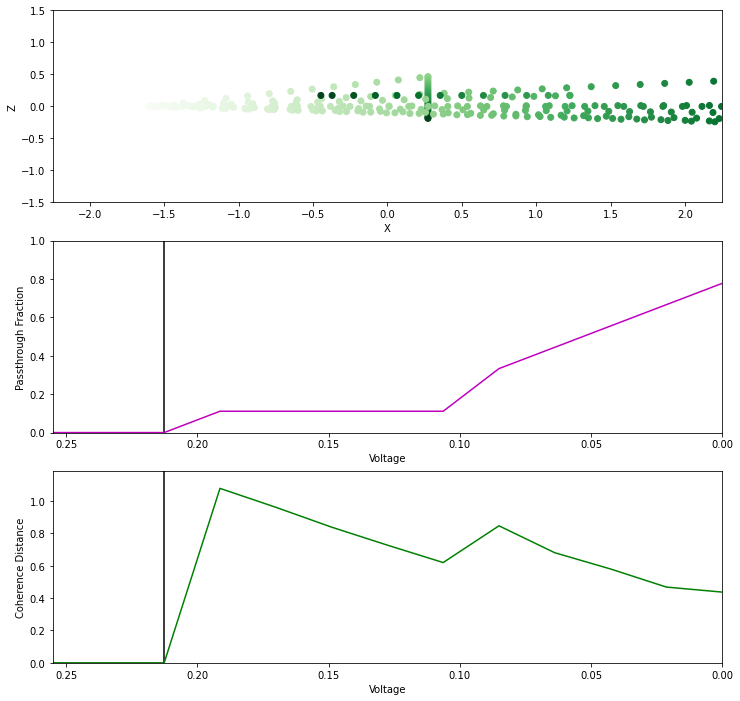

In [39]:
# Generate cohort of particles
particles = libem.ChargedParticle3D.generate_particles(10, None,
                                                       PARTICLE_OPTS["mass"][0],
                                                       PARTICLE_OPTS["charge"][0],
                                                       PARTICLE_OPTS["initial_loc"][0],
                                                       PARTICLE_OPTS["initial_v"][0],
                                                       PARTICLE_OPTS["mass"][1],
                                                       PARTICLE_OPTS["charge"][1],
                                                       PARTICLE_OPTS["initial_loc"][1],
                                                       PARTICLE_OPTS["initial_v"][1],
                                                       PARTICLE_OPTS["bounce_coef"])
particles = [p for p in particles if p.charge > 0]

max_qke = max([abs(p.charge) for p in particles]) * 0.5 * max([p.mass for p in particles]) * \
            (max([np.linalg.norm(p.initial_velocity) for p in particles]))**2

voltage_range = np.arange(0,  1.25 * min_v_qke_ratio * max_qke, min_v_qke_ratio * max_qke / 10)[::-1]
passthrough = np.zeros(voltage_range.shape)
coherence = np.zeros(voltage_range.shape)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
video = libvis.VideoMaker(fig, axes)

print("Running Coherence Simulation")

for i, voltage in enumerate(voltage_range):
    sim, enf = generate_dfgate(
            (-(DFDIM["length"] / 2.0) + DFDIM["boxwall"], -(DFDIM["box"] / 2.0) + DFDIM["boxwall"], -(DFDIM["panel_gap"] / 2.0), DFDIM["panel_gap"] / 2.0),
            (DFDIM["panel_l"], DFDIM["panel_w"] - (2 * DFDIM["boxwall"]), DFDIM["panel_h"]),
            0, 0, voltage)
    sim.compute(enf)
    sim.get_efield()
    
    passed = []
    passed_v = []
    for j, p in enumerate(particles):
        p.sim = sim
        p.compute_motion((0, (DFDIM["length"] * 1.5) / abs(p.initial_velocity[0])))
        if p.position[0][-1] > (DFDIM["length"] / 2.0):
            passed.append(p.position[:,-1])
            passed_v.append(p.velocity[:,-1])
        print("\rVoltage " + str(round(voltage, 2)) + ", Particle " + str(j+1).rjust(3), end="")
            
    if len(passed) > 0:
        passed = np.array(passed)
        passed_v = np.array(passed_v)
        passthrough[i] = passed.shape[0] / len(particles)
        extrapolate_times = (passed[:,0] - (1.5 * DFDIM["length"] / 2.0)) / np.abs(passed_v[:,0])
        extrapolated_locs = np.array(
            [(extrapolate_times[i] * passed_v[i,1:]) +  passed[i,1:] for i in range(passed.shape[0])])
        coherence[i] = np.average(np.linalg.norm(extrapolated_locs, axis=1))
    
    video.new_frame()
        
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Z")
    if voltage != 0:
        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=1)
        libvis.Visualizations.colormesh_2d(sim2d, color_norm=voltage, graph_ax=axes[0])
        axes[0].axvline(1.5 * DFDIM["length"] / 2.0, color="k")
    for p in particles:
        libvis.Visualizations.trajectory_2d(p.time, p.position, axis=1, graph_ax=axes[0])
    axes[0].set_xlim((-(DFDIM["length"] / 2.0) * 1.5, (DFDIM["length"] / 2.0) * 1.5))
    axes[0].set_ylim((-(DFDIM["box"] / 2.0) * 1.5, (DFDIM["box"] / 2.0) * 1.5))
        
    axes[1].set_xlabel("Voltage")
    axes[1].set_ylabel("Passthrough Fraction")
    axes[1].axvline(max_qke * min_v_qke_ratio, color="k")
    axes[1].set_xlim((voltage_range[0], voltage_range[-1]))
    axes[1].set_ylim((0, 1))
    axes[1].plot(np.array(voltage_range[:i+1]), np.array(passthrough[:i+1]), color="m")
    
    axes[2].set_xlabel("Voltage")
    axes[2].set_ylabel("Coherence Distance")
    axes[2].axvline(max_qke * min_v_qke_ratio, color="k")
    axes[2].set_xlim((voltage_range[0], voltage_range[-1]))
    axes[2].set_ylim((0, max(max(coherence[:i+1]), 1) * 1.1))
    axes[2].plot(np.array(voltage_range[:i+1]), np.array(coherence[:i+1]), color="g")
        
    video.draw_frame()
    
video.make_movie(OUT_D, "beam_passthrough.mp4")